In [1]:
import sys
import os
from pathlib import Path
from utils import build_features

import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme(style="darkgrid")

%load_ext autoreload
%autoreload 2

## Loading data and cleaning it

In [3]:
comp_prices_df = pd.read_csv("data/comp_prices.csv")
sales_df = pd.read_csv("data/sales.csv")

In [4]:
df = build_features(sales_df, comp_prices_df)

# Outliers
df = df[df.date != pd.to_datetime("2015-10-14")]

In [5]:
df

,prod_id,date,price,qty_order,min,max,mean,median,qty_day_shift,diff_min_pct,diff_mean_pct,qty_order_log
0,P1,2015-03-16,1402.312500,24.0,1362.50,1499.0,1446.137500,1461.525,48.0,0.029220,-0.030305,3.178054
1,P1,2015-03-17,1355.201071,28.0,1362.50,1499.0,1418.258333,1393.275,24.0,-0.005357,-0.044461,3.332205
2,P1,2015-03-18,1358.555075,67.0,1362.50,1499.0,1429.410000,1424.050,28.0,-0.002895,-0.049569,4.204693
3,P1,2015-03-19,1355.095217,46.0,1304.13,1499.0,1396.545000,1391.525,67.0,0.039080,-0.029680,3.828641
4,P1,2015-03-20,1384.065789,19.0,1304.13,1499.0,1440.454286,1499.000,46.0,0.061294,-0.039146,2.944439
...,...,...,...,...,...,...,...,...,...,...,...,...
1886,P9,2015-10-09,389.691600,175.0,395.85,569.0,433.183846,395.930,370.0,-0.015557,-0.100401,5.164786
1887,P9,2015-10-10,391.380233,129.0,395.82,569.0,433.146923,395.850,175.0,-0.011217,-0.096426,4.859812
1888,P9,2015-10-11,390.586437,87.0,395.78,569.0,444.330000,397.910,129.0,-0.013122,-0.120954,4.465908
1889,P9,2015-10-12,391.779727,110.0,395.76,569.0,439.895455,395.780,87.0,-0.010057,-0.109380,4.700480


## Quick visualization

In [6]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [10]:
prod_id = "P2"
sel_df = df[df.prod_id == prod_id]
X = sel_df[["diff_mean_pct", "qty_day_shift"]]
X["qty_day_shift"] = np.log(X["qty_day_shift"])
y = np.log(sel_df[["qty_order"]])
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/tmp/ipykernel_3592/2296615661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["qty_day_shift"] = np.log(X["qty_day_shift"])
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              qty_order   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     237.4
Date:                Fri, 27 Aug 2021   Prob (F-statistic):           5.05e-61
Time:                        23:31:23   Log-Likelihood:                -298.58
No. Observations:                 283   AIC:                             603.2
Df Residuals:                     280   BIC:                             614.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.0816      0.196     10.641      0.000       1.697       2.467
diff_mean_pct    -7.4650      0.840     -8.888      0.000      -9.118      -5.812
qty_day_shift     0.5636      0.040     13.920      0.000       0.484       0.643
==============================================================================
Omnibus:                       13.041   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.189
Skew:                           0.135   Prob(JB):                     7.56e-07
Kurtosis:                       4.522   Cond. No.                         99.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

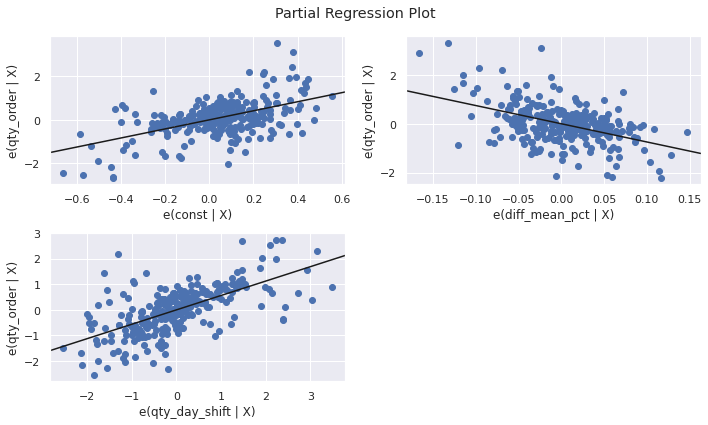

In [11]:

fig = sm.graphics.plot_partregress_grid(results)
fig.set_size_inches(10, 6)
fig.tight_layout(pad=1.0)


## Cross-validation score

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

for prod_id in df.prod_id.unique():
    sel_df = df[df.prod_id == prod_id]
    X = sel_df.loc[:, ["diff_mean_pct", "qty_day_shift"]]
    X["qty_day_shift"] = np.log(X["qty_day_shift"])
    y = np.log(sel_df[["qty_order"]])
    reg = LinearRegression()
    mean_sqrt_error = np.exp(-cross_val_score(reg, X, y, cv=20, scoring="neg_root_mean_squared_error"))
    #plt.hist(mean_sqrt_error)
    #plt.show()
    print(f"Prod {prod_id}")
    print(f"Mean squared error: {np.mean(mean_sqrt_error)}")

Prod P1
Mean squared error: 1.8107850214529542
Prod P2
Mean squared error: 2.0086577822118383
Prod P3
Mean squared error: 2.011408786466211
Prod P4
Mean squared error: 2.48257900098937
Prod P5
Mean squared error: 2.531509883617754
Prod P6
Mean squared error: 2.0885492476056697
Prod P7
Mean squared error: 2.049810134443695
Prod P8
Mean squared error: 1.8253968622559846
Prod P9
Mean squared error: 1.8447976850866543
